In [114]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("../BAMVAE")
from VAE_v2 import VAE2,complete_train_and_test
from MNISTLoader import MNIST_Loader
import torch.optim as optim
from plot_images import plot_images
import random

import torch.nn as nn

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
device = torch.device("mps") # GPU acceleration for Mac
mnist=MNIST_Loader(bs=128,normalise=True,
                        root_folder='../mnist_data')
train_dataset,test_dataset=mnist.__getdatasets__()
train_loader,test_loader=mnist.__getdataloaders__()

#### Throw exception when nan
torch.autograd.set_detect_anomaly(True)

In [116]:
z_dim=2
learning_rate=1e-3
nb_epochs=10
# on previous models, tried cnL1=8,cnL2=16,cnL3=32

vae=VAE2(name=f"VAE_{z_dim}_dim",z_dim=z_dim,cnL1=16,cnL2=32,cnL3=64).to(device)

optimizer= optim.Adam(vae.parameters(),lr=learning_rate)
print(vae.print_nb_params())

The model has 440 661 parameters
440661


In [117]:
train_losses,test_losses=complete_train_and_test(vae,train_loader=train_loader,
                            test_loader=test_loader,optimizer=optimizer,
                            nb_epochs=nb_epochs,view_latent=False,
                            test_dataset=test_dataset,
                            k1=0.9,k2=0.1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 888.705627
Train Epoch: 1 [12800/60000 (21%)]	Loss: 510.580627
Train Epoch: 1 [25600/60000 (43%)]	Loss: 496.873871
Train Epoch: 1 [38400/60000 (64%)]	Loss: 486.059540
Train Epoch: 1 [51200/60000 (85%)]	Loss: 499.806091
====> Epoch: 1 Average loss: 504.0919
====> Test set loss: 487.8283
Train Epoch: 2 [0/60000 (0%)]	Loss: 460.042389
Train Epoch: 2 [12800/60000 (21%)]	Loss: 481.431976
Train Epoch: 2 [25600/60000 (43%)]	Loss: 474.749481
Train Epoch: 2 [38400/60000 (64%)]	Loss: 464.899292
Train Epoch: 2 [51200/60000 (85%)]	Loss: 462.979248
====> Epoch: 2 Average loss: 475.5294
====> Test set loss: 477.7297
Train Epoch: 3 [0/60000 (0%)]	Loss: 490.016235
Train Epoch: 3 [12800/60000 (21%)]	Loss: 449.183472
Train Epoch: 3 [25600/60000 (43%)]	Loss: 469.812653
Train Epoch: 3 [38400/60000 (64%)]	Loss: 467.347687
Train Epoch: 3 [51200/60000 (85%)]	Loss: 462.033417
====> Epoch: 3 Average loss: 466.7394
====> Test set loss: 469.5555
Train Epoch: 4 [0/60000 (0%)]	L

In [105]:
print(f"There where {vae.counter_nan} clashes of nan values in the process with {nb_epochs} epochs")

There where 0 clashes of nan values in the process with 30 epochs


Text(0.5, 1.0, 'Train and test losses with CNN VAE')

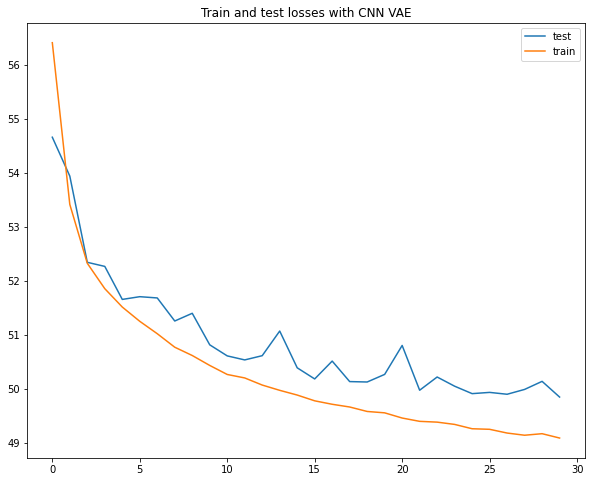

In [106]:
plt.figure(figsize=(10,8))
plt.plot(range(0,nb_epochs),test_losses,label="test")
plt.plot(range(0,nb_epochs),train_losses,label="train")
plt.xticks(np.arange(0,nb_epochs+1,5))
plt.legend()
plt.title("Train and test losses with CNN VAE")
# plt.savefig("../images/Train and test losses with CNN VAE 50 epochs Zdim=16.png")

In [107]:
for k,(batch,label) in enumerate(train_loader):
    if k!=2:
        pass
    else:
        print(k,end="\r")
        vae.eval()
        rec,_,_=vae(batch.to(device))
        break
    

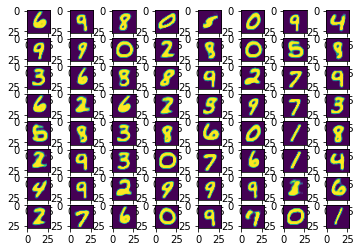

In [108]:
fig,axs=plt.subplots(8,8)
axs=axs.ravel()
for k in range(8*8):
    axs[k].imshow(rec.detach().cpu().numpy().reshape(-1,28,28)[k])

In [ ]:
# vae.save_model(model_path="../models/newVAE30epochs_zdim=16.h5")

In [109]:
gen_images=vae.generate_from_noise(nb_images=64)
gen_images_np=gen_images.detach().cpu().numpy()
gen_images_np=gen_images_np.reshape(-1,28,28)
# np.save("../generated_data/newmodelgeneration.npy",gen_images_np)

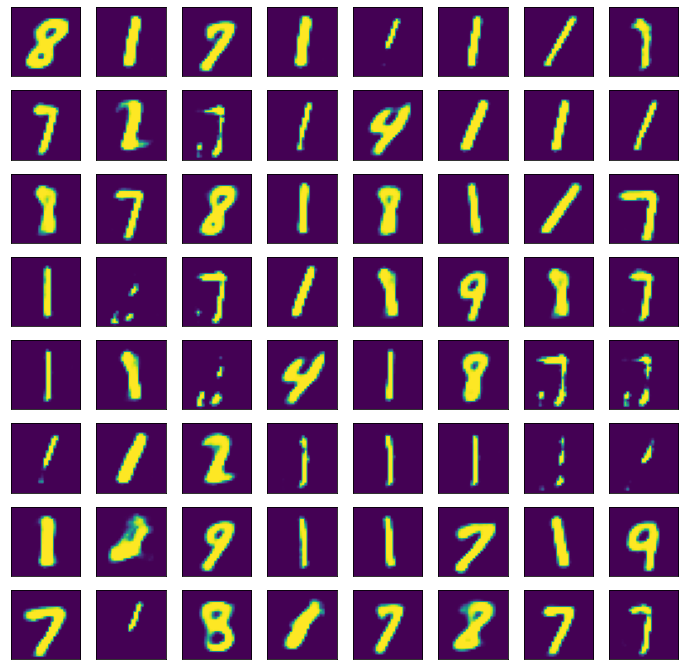

In [110]:
fig,axs=plt.subplots(8,8,figsize=(12,12))
axs=axs.ravel()
for k in range(64):
    axs[k].imshow(gen_images_np[k])
    axs[k].set_xticks([])
    axs[k].set_yticks([])

In [111]:
grid_generated=vae.generate_images(1024)

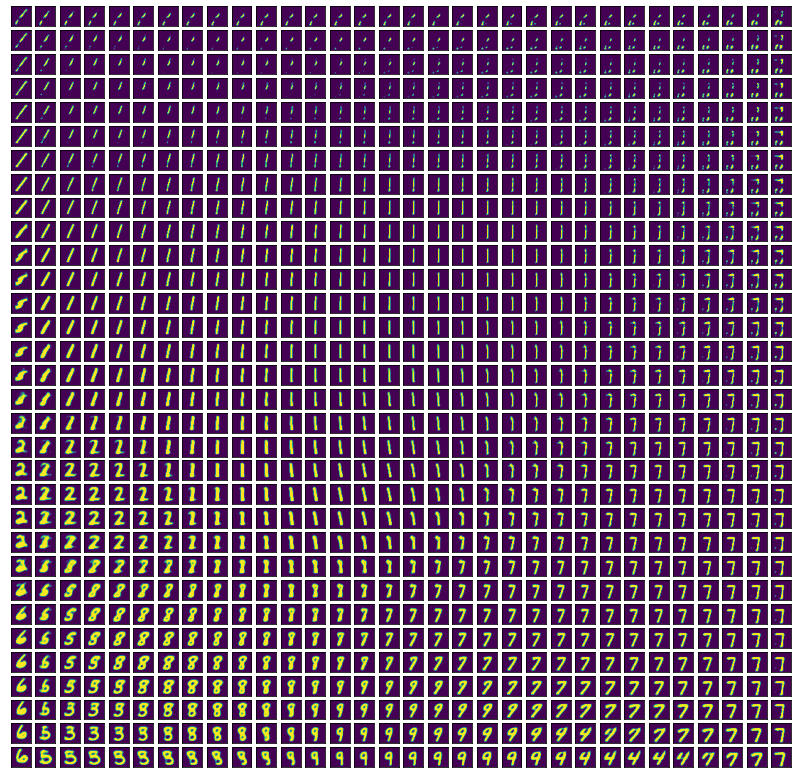

In [112]:
fig,axs=plt.subplots(32,32,figsize=(14,14))
axs=axs.ravel()
for k in range(1024):
    axs[k].imshow(grid_generated[k])
    axs[k].set_xticks([])
    axs[k].set_yticks([])

## View the latent space

In [92]:
visualisation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024*10, shuffle=False)

for k,(test_images, test_labels) in enumerate(visualisation_loader):  
    if k==1:
        break

In [93]:
vae.eval()
test_images=test_images.to(device)
# data = data.to(device)
# recon, mu, log_var = vae(data)
with torch.no_grad():
    avg,_=vae.encoder(test_images)
avg=avg.cpu().numpy()

In [70]:
# # 1D
# plt.figure(figsize=(12,8))
# plt.scatter(avg[:,0],test_labels,c=test_labels ,cmap='tab10', alpha=0.5, s=20)
# plt.colorbar()
# plt.title(f"Latent space with dimension {vae.z_dim}")
# plt.ylabel("Real label")
# plt.xlabel("1D lLatent space")
# _=plt.yticks(range(1,10))
# # plt.savefig("../images/Latent space dim 1 with 15 epochs.png")

Text(0.5, 1.0, 'Latent space with dimension 2')

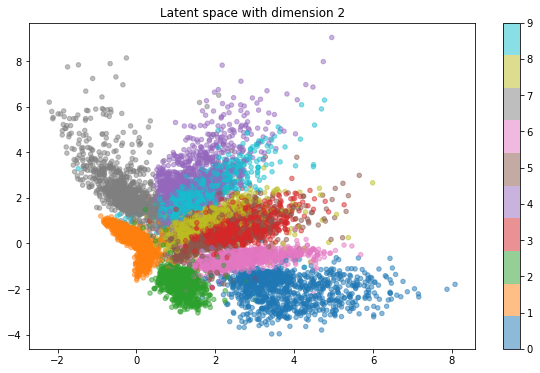

In [113]:
plt.figure(figsize=(10,6))
plt.scatter(avg[:,0],avg[:,1],c=test_labels ,cmap='tab10', alpha=0.5, s=20)
plt.colorbar()
plt.title(f"Latent space with dimension {vae.z_dim}")
# plt.savefig("Latent space dim 2.png")

## Plotting the latent space, dimension against dimension

Text(0.5, 0.98, 'Visualisation of latent space with 2 dimensions against each other')

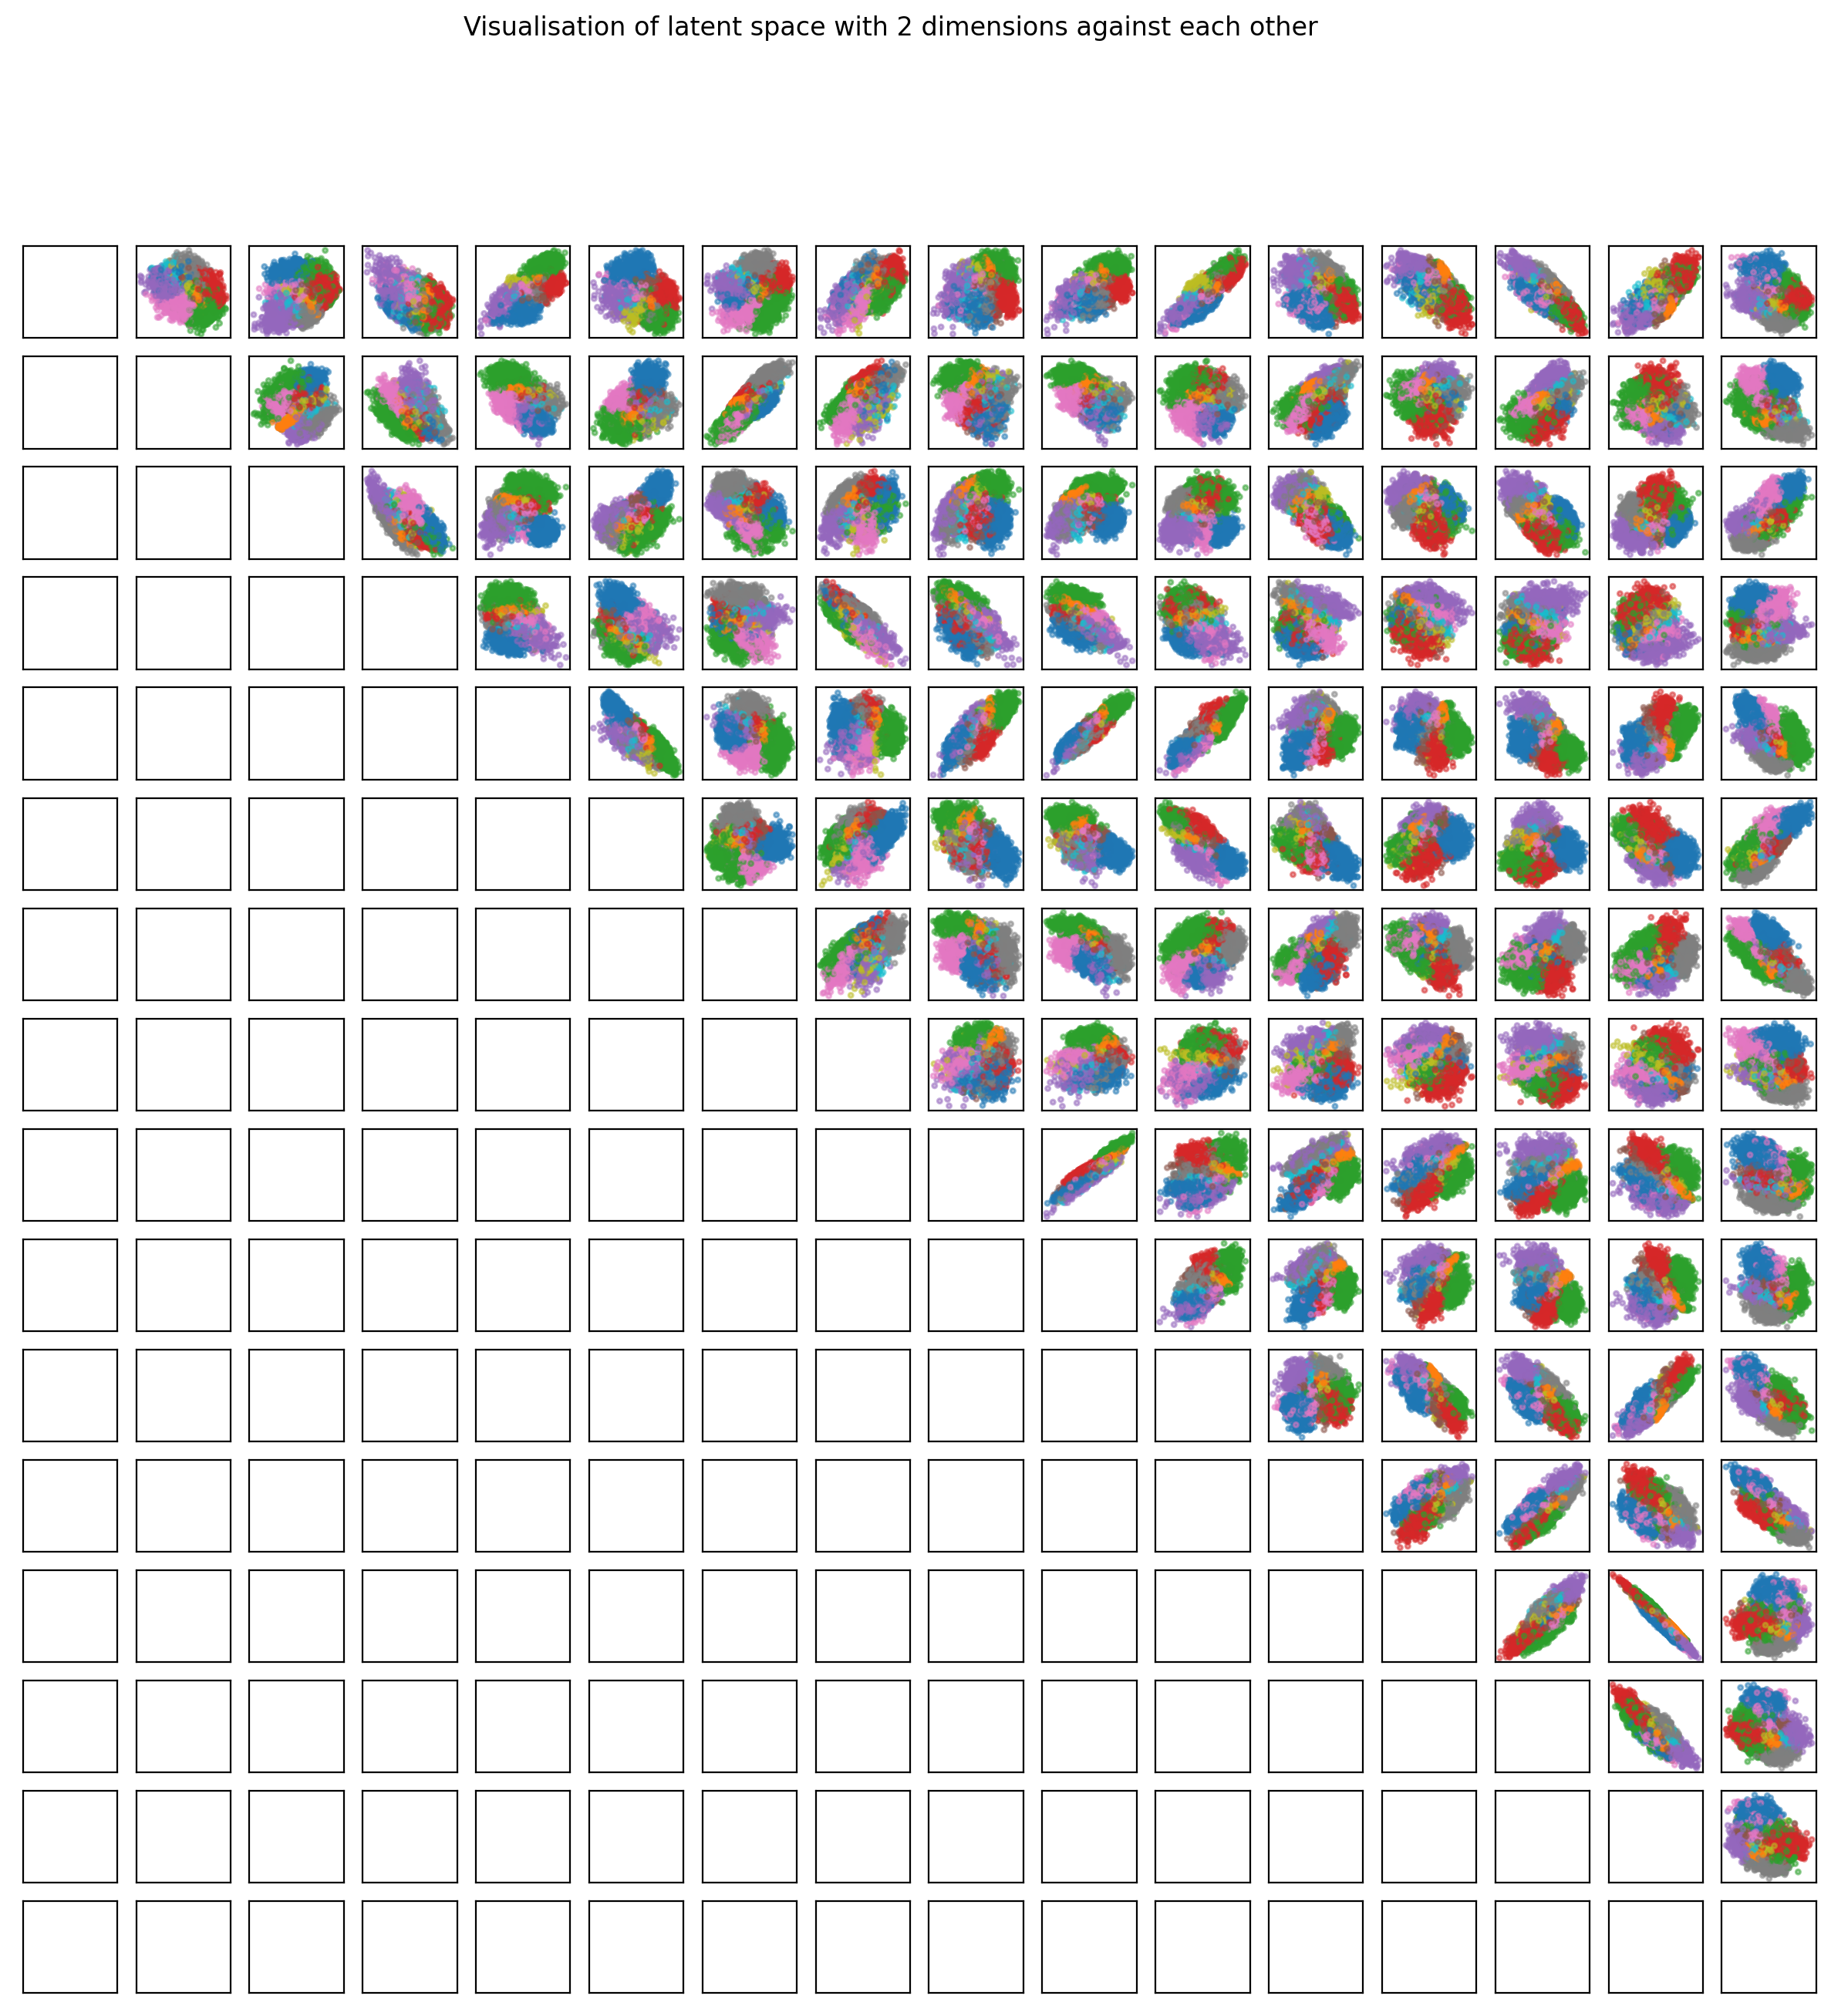

In [17]:
# fig,axs=plt.subplots(16,16,figsize=(15,15),dpi=200)
# # axs=axs.ravel()
# for k2 in range(16):
#     for k1 in range(k2):
#         ax=axs[k1][k2]
#         ax.scatter(avg[:,k1],avg[:,k2],c=test_labels ,cmap='tab10', alpha=0.5, s=5)
# for ax in axs.ravel():
#     ax.set_xticks([])
#     ax.set_yticks([])
# # axs[k1][k2].colorbar()
# fig.suptitle(f"Visualisation of latent space with 2 dimensions against each other")
# # plt.savefig("../images/Visualisation latent space dim 16.png")

# Reconstruct images

In [66]:
inIm=np.load("../generated_data/10 images MNIST.npy")
inIm=torch.tensor(inIm).to(device)

reconIm,mu,logvar=vae(inIm)
reconIm=reconIm.detach().cpu().numpy().reshape(-1,28,28)

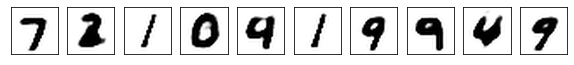

In [67]:
plot_images(reconIm)

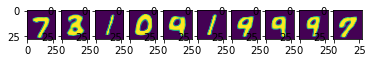

In [51]:
fig,axs=plt.subplots(1,10)
axs=axs.ravel()
for k in range(10):
    axs[k].imshow(reconIm[k])
    # axs[k].x_ticks([])